In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

titanic = sns.load_dataset("titanic")

titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


La **classification** est une tâche de ML qupervisée qui consiste à prédire une catégorie.

**Types de classification**:
- **Binaire** : 2 classe (Survivant/Décédé)
- **Multi-class** : > 2 classes

**Algorithme courant** :
- Régression logistique
- Arbre de décision
- Random Forest

# Analyse exploratoire

Text(0, 0.5, 'taux de survie')

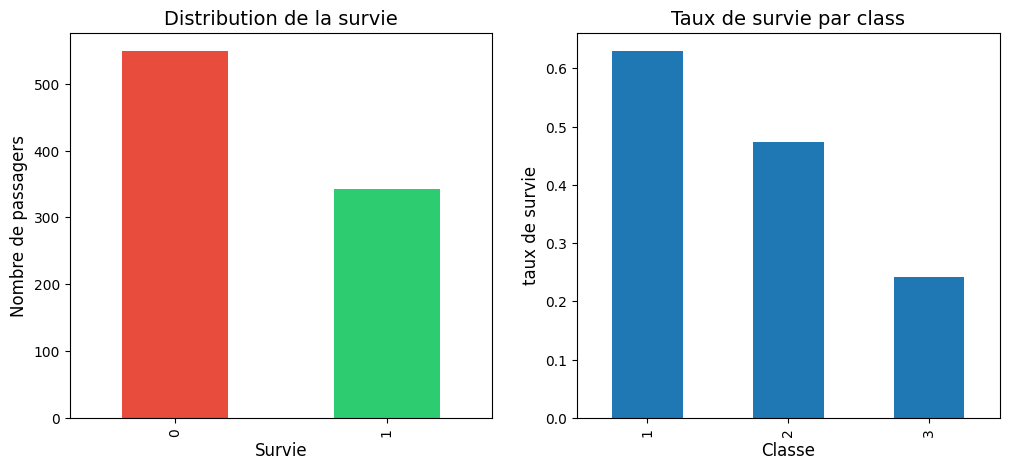

In [2]:
plt.figure(figsize=(12,5))

# Distribution globale de la survie
plt.subplot(121)
titanic["survived"].value_counts().plot(kind="bar", color=["#E74C3C", "#2ECC71"])
plt.title("Distribution de la survie", fontsize=14)
plt.xlabel("Survie", fontsize=12)
plt.ylabel("Nombre de passagers", fontsize=12)

plt.subplot(122)
survival_class = titanic.groupby("pclass")["survived"].mean()
survival_class.plot(kind="bar")
plt.title("Taux de survie par class", fontsize=14)
plt.xlabel("Classe", fontsize=12)
plt.ylabel("taux de survie", fontsize=12)

# Gestion des valeurs manquantes

In [3]:
def analyse_missing_date(df: pd.DataFrame) -> pd.DataFrame:
    missing = df.isnull().sum()
    missing_pct = 100 * missing / len(df)
    df_missing = pd.DataFrame({
        "Colonnes": missing.index,
        "Valeurs manquantes": missing.values,
        "Pourcentages": missing_pct.values
    })
    df_missing = df_missing[df_missing["Valeurs manquantes"] > 0].sort_values("Pourcentages", ascending=False)
    return df_missing

missing_data = analyse_missing_date(titanic)
missing_data

,Colonnes,Valeurs manquantes,Pourcentages
11,deck,688,77.216611
3,age,177,19.865320
7,embarked,2,0.224467
12,embark_town,2,0.224467


# Prétraitement des données

In [4]:
features_to_keep = ["pclass", "sex", "age", "sibsp", "fare", "parch", "embarked"]
target = "survived"

X = titanic[features_to_keep].copy()
y = titanic[target].copy()

# Identifiation des types de colonnes
numeric_features = X.select_dtypes(include=["int", "float"]).columns.to_list()
categorical_features = X.select_dtypes(include=["object"]).columns.to_list()

print(f"Variables numériques : {numeric_features}")
print(f"Variables catégorielles : {categorical_features}")

Variables numériques : ['pclass', 'age', 'sibsp', 'fare', 'parch']
Variables catégorielles : ['sex', 'embarked']


## Pipeline

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Pipeline pour les variables numériques
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), # remplacer les NaN par la médiane
        ("scaler", StandardScaler()), # Normaliser les données
    ]
)

# Pipeline pour les variables catégorielles
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")), # remplacer les NaN par "missing"
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Appliquer les pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Séparation Train/Test

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2, # 20% test 80% train
    random_state=42, # seed
    stratify=y, # Déséquilibre des classes
    shuffle=True,
)

print(f"Train : {y_train.mean():.1%} de survivants")
print(f"Train : {y_test.mean():.1%} de survivants")

Train : 38.3% de survivants
Train : 38.5% de survivants


## Régression logistique

Malgré son nom, la régression logistique est un algorithme de classification.

- Le seuil de décision (par défaut 0.5) : si P > 0.5 => classe 1, sinon classe 0

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

ml_pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor), # Transformation des données
        ("classifier", LogisticRegression(random_state=42, max_iter=1_000)), # Modèle
    ]
)

# Entrainement du modèle sur les données d'entraînement
ml_pipeline.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred = ml_pipeline.predict(X_test)

# Calcul du taux de bonnes prédictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy:.2%}")

Accuracy : 80.45%


## Sauvegarde du modèle

**joblib** permet de sauvegarder un modèle entraîné pour :
- Eviter de ré-entraîner le modèle à chaque utilisation
- Déployer en production
- Partager

La pipeline complète (preprocessing + modèle) est sauvegardé.

In [8]:
import joblib

# Sauvegarde dans un fichier pkl
model_file_name = "C:/Users/Administrateur/Documents/M2i_CDSD_TDTP/scikit_learn/demos/titanic_survival_model.pkl"
joblib.dump(ml_pipeline, model_file_name)

['C:/Users/Administrateur/Documents/M2i_CDSD_TDTP/scikit_learn/demos/titanic_survival_model.pkl']

In [9]:
# Chargement du modèle

load_model = joblib.load(model_file_name)

new_passenger = pd.DataFrame({
    "pclass": [1],
    "sex": ["male"],
    "age": [30],
    "sibsp": [0],
    "fare": [80],
    "parch": [0],
    "embarked": ["S"],
})

prediction = load_model.predict(new_passenger)
proba = load_model.predict_proba(new_passenger)

print(f"Survie : {"OUI" if prediction[0] == 1 else "NON"}")
print(f"proba survie : {proba[0][1]:.1%}")

Survie : NON
proba survie : 49.2%


## Evaluation du modèle

- **Précision** : Parmi les prédictions positives, combien sont correectes ?
- **Recall** : Parmi les vrais positifs, combien ont été détectés ?
  - Important quand les faux négatifs sont coûteux
- **F1-score** : Moyenne harmonique precision*recall/(precision+recall)

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(classification_report(y_test, y_pred, target_names=["Décédé", "Vivant"]))

              precision    recall  f1-score   support

      Décédé       0.81      0.89      0.85       110
      Vivant       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



<Figure size 1200x700 with 0 Axes>

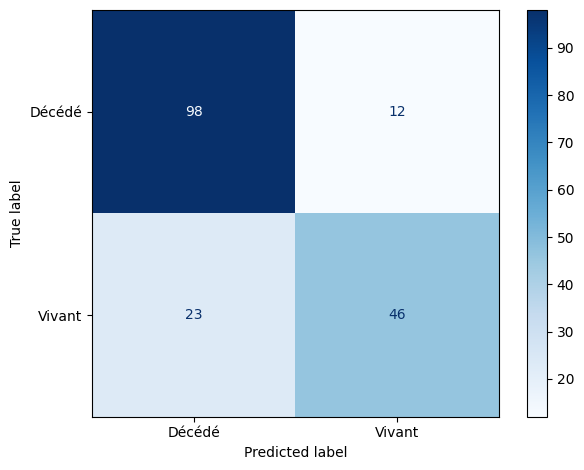

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,7))
display = ConfusionMatrixDisplay(cm, display_labels=["Décédé", "Vivant"])
display.plot(cmap="Blues")
plt.tight_layout()